In [1]:
%reload_ext autoreload
%autoreload 2

import sys

sys.path.append(".")
sys.path.append("..")
sys.path.append("../..")

In [2]:
from uniflow.flow.client import TransformClient
from uniflow.flow.config import TransformExpandReduceConfig
from uniflow.viz import Viz

/opt/anaconda3/envs/uniflow/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# client = Client("expand_reduce_flow")
client = TransformClient(TransformExpandReduceConfig())
input = [{"How are you?": "Fine.", "Who are you?": "I am Bob."}, {"Where are you?": "I am at home.", "What are you doing?": "Coding."}]
output = client.run(input)

100%|██████████| 2/2 [00:00<00:00, 13706.88it/s]


In [8]:
output

[{'output': [{'How are you?': 'Fine.', 'Who are you?': 'I am Bob.'}],
  'root': <uniflow.node.Node at 0x118239790>},
 {'output': [{'Where are you?': 'I am at home.',
    'What are you doing?': 'Coding.'}],
  'root': <uniflow.node.Node at 0x11822e710>}]

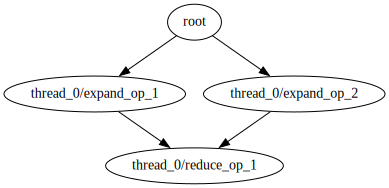

In [9]:
graph = Viz.to_digraph(output[0]["root"])
display(graph)

In [10]:
graph = Viz.to_digraph(output[1]["root"])


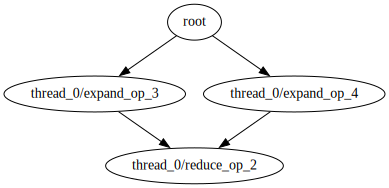

In [11]:
display(graph)

Initial test shows ExpandReduce operations are working as expected.

We'll perform further testing to verify it passes all edge cases.
(Note since the instructions weren't clear on the requirements of the functions and classes, as well as some other implmentation details, I made design choices which I think best aligns with the use case of ExpandReduceFlow)

In [12]:
import unittest
from uniflow.node import Node
from uniflow.op.basic.expand_op import ExpandOp
from uniflow.op.basic.reduce_op import ReduceOp
from uniflow.flow.transform.transform_expand_reduce_flow import TransformExpandReduceFlow
from uniflow.constants import OUTPUT_NAME, ROOT_NAME

In [13]:
class TestExpandOp(unittest.TestCase):
    def test_call(self):
        # Test with one input node
        input_node = Node(name="root_node", value_dict={"1": "2", "3": "4", "5": "6", "7": "8"})
        op = ExpandOp("expand_op")
        op([input_node])
        self.assertEqual(
            input_node.flatten(),
            [
                {
                    "is_end": False,
                    "name": "root_node",
                    "next_nodes": ["expand_op_1", "expand_op_2"],
                    "prev_nodes": [],
                    "value_dict": {"1": "2", "3": "4", "5": "6", "7": "8"},
                },
                {
                    "is_end": False,
                    "name": "expand_op_1",
                    "next_nodes": [],
                    "prev_nodes": ["root_node"],
                    "value_dict": {"1": "2", "3": "4"},
                },
                {
                    "is_end": False,
                    "name": "expand_op_2",
                    "next_nodes": [],
                    "prev_nodes": ["root_node"],
                    "value_dict": {"5": "6", "7": "8"},
                },
            ],
        )

testExpandOp = TestExpandOp()
testExpandOp.test_call()

In [14]:
class TestReduceOp(unittest.TestCase):
    def test_call(self):
        input_node1 = Node(name="input_node1", value_dict={"1": "2", "3": "4"})
        input_node2 = Node(name="input_node2", value_dict={"5": "6", "7": "8"})
        op = ReduceOp("reduce_op")
        op(input_node1, input_node2)
        self.assertEqual(
            input_node1.flatten(),
            [
                {
                    "is_end": False,
                    "name": 'input_node1',
                    "next_nodes": ["reduce_op_1"],
                    "prev_nodes": [],
                    "value_dict": {"1": "2", "3": "4"},
                },
                {
                    "is_end": False,
                    "name": "reduce_op_1",
                    "next_nodes": [],
                    "prev_nodes": ['input_node1', 'input_node2'],
                    "value_dict": {"1 5": ['2', '6'], '3 7': ['4', '8']},
                },
            ],
        )
        self.assertEqual(
            input_node2.flatten(),
            [
                {
                    "is_end": False,
                    "name": 'input_node2',
                    "next_nodes": ["reduce_op_1"],
                    "prev_nodes": [],
                    "value_dict": {'5': '6', '7': '8'},
                },
                {
                    "is_end": False,
                    "name": "reduce_op_1",
                    "next_nodes": [],
                    "prev_nodes": ['input_node1', 'input_node2'],
                    "value_dict": {'1 5': ['2', '6'], '3 7': ['4', '8']},
                },
            ],
        )

testReduceOp = TestReduceOp()
testReduceOp.test_call()

In [15]:
class TestFlow(unittest.TestCase):
    def test_flow(self):
        # Test __call__ method
        flow = TransformExpandReduceFlow()
        input_dict = {"1": "2", "3": "4", "5": "6", "7": "8"}
        output_dict = flow(input_dict)
        self.assertEqual(output_dict[OUTPUT_NAME], [{'1 5': ['2', '6'], '3 7': ['4', '8']}])

        # Test root property
        self.assertEqual(flow.root.name, ROOT_NAME)
        self.assertEqual(flow.root.value_dict, input_dict)

        # Test _enter method
        nodes = flow._enter(input_dict)
        self.assertEqual(len(nodes), 1)
        self.assertEqual(nodes[0].name, ROOT_NAME)
        self.assertEqual(nodes[0].value_dict, input_dict)

testFlow = TestFlow()
testFlow.test_flow()